**Google Colab to Drive connection**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks/Other/sample-task-DS-predictive-maintenance/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/Other/sample-task-DS-predictive-maintenance


**Libraries in need**

In [2]:
#arrays and dataframes
import numpy as np
import pandas as pd


#visual and illustrations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#just to ignore warining pop-ups
import warnings
warnings.simplefilter(action='ignore', category=(DeprecationWarning, FutureWarning))


#for data processing
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


#for neural network and its core requirements
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Bidirectional, LSTM, Dropout, Average
from keras import optimizers, regularizers

Using TensorFlow backend.


**Reading all the data from file**

In [0]:
#using pandas read csv to read all data sheets

#training set
train_df = pd.read_csv('data/train.csv')

#real answers
rul_df = pd.read_csv('data/RUL.csv')

#testing set
test_df = pd.read_csv('data/test.csv')

**Checking training data**

- As shown in the figure above, training dataset also contains some information about cycles each engine run before failure.

- Sample five rows of training data. And around 160k data segments for unique 260 engines across four different datasets.

In [4]:
#pandas head to view just first five rows only
train_df.head()

,dataset_id,unit_id,cycle,setting 1,setting 2,setting 3,sensor 1,sensor 2,sensor 3,sensor 4,...,sensor 12,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21
0,FD004,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,FD004,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,FD004,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,FD004,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,FD004,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


- Starting with the training dataset, it contains three settings and 21 sensor recordings where a number of engines were run until failure. As mentioned in the task statement given, the engines start at a different level of wear and as some fail sooner than others the engines have run different number of cycles and also data is collected as a number of datasets each with its own engines.

In [5]:
#pandas info can get an overview, also i have checked describe function too, but not shown here
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160359 entries, 0 to 160358
Data columns (total 27 columns):
dataset_id    160359 non-null object
unit_id       160359 non-null int64
cycle         160359 non-null int64
setting 1     160359 non-null float64
setting 2     160359 non-null float64
setting 3     160359 non-null float64
sensor 1      160359 non-null float64
sensor 2      160359 non-null float64
sensor 3      160359 non-null float64
sensor 4      160359 non-null float64
sensor 5      160359 non-null float64
sensor 6      160359 non-null float64
sensor 7      160359 non-null float64
sensor 8      160359 non-null float64
sensor 9      160359 non-null float64
sensor 10     160359 non-null float64
sensor 11     160359 non-null float64
sensor 12     160359 non-null float64
sensor 13     160359 non-null float64
sensor 14     160359 non-null float64
sensor 15     160359 non-null float64
sensor 16     160359 non-null float64
sensor 17     160359 non-null int64
sensor 18     160359 n

- Test data contains over 100k rows where the real results are in total just 707 rows. Test data provides data of engines until a particular engine fails starting from its first cycle to the last, where the real results contains only the real useful lifetime left of that engine.

In [6]:
#details of the real results
rul_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 3 columns):
dataset_id    707 non-null object
unit_id       707 non-null int64
rul           707 non-null int64
dtypes: int64(2), object(1)
memory usage: 16.6+ KB


In [7]:
#some insight of test data
test_df.describe()

,unit_id,cycle,setting 1,setting 2,setting 3,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,...,sensor 12,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21
count,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,...,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000
mean,103.119117,95.406589,17.243810,0.410887,95.748591,485.791314,597.153354,1464.738375,1257.240382,9.887805,...,338.437014,2349.811235,8084.687648,9.046593,0.025039,360.088096,2273.841797,98.398282,25.949868,15.570426
std,71.370362,74.311486,16.530141,0.368078,12.328151,30.426804,42.430629,117.856835,135.728855,4.265536,...,164.110284,110.890533,78.956087,0.748390,0.005000,30.932463,142.218102,4.644631,11.701010,7.020590
min,1.000000,1.000000,-0.008700,-0.000600,60.000000,445.000000,535.410000,1240.940000,1024.900000,3.910000,...,128.260000,2027.740000,7849.800000,8.198000,0.020000,302.000000,1915.000000,84.930000,10.180000,6.123100
25%,43.000000,38.000000,0.001300,0.000200,100.000000,449.440000,549.780000,1355.140000,1124.030000,5.480000,...,164.800000,2387.950000,8068.360000,8.425600,0.020000,331.000000,2212.000000,100.000000,14.340000,8.607300
50%,87.000000,80.000000,19.998200,0.620000,100.000000,489.050000,605.530000,1490.160000,1262.850000,9.350000,...,317.630000,2388.050000,8113.100000,9.108500,0.030000,367.000000,2319.000000,100.000000,24.780000,14.872400
75%,159.000000,135.000000,35.001500,0.840000,100.000000,518.670000,642.200000,1584.810000,1399.460000,14.620000,...,521.590000,2388.110000,8136.630000,9.333900,0.030000,392.000000,2388.000000,100.000000,38.880000,23.331000
max,259.000000,486.000000,42.008000,0.842000,100.000000,518.670000,644.320000,1609.690000,1434.120000,14.620000,...,536.600000,2389.960000,8243.100000,11.030000,0.030000,398.000000,2388.000000,100.000000,39.750000,23.849600


**Missing Data ?**

- By making a heat-map passing not null data gives a clear overview of both training and test data for any missing row, columns or cells.

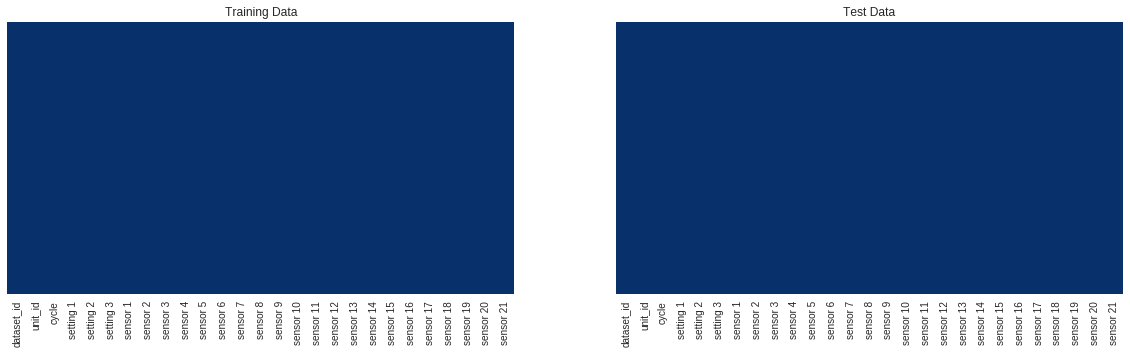

In [8]:
#plotting a heatmap for training data to check any mising data on board

#since my notebook background is dark, i always use facecolor white option
plt.figure(figsize=(20,5), facecolor='white')

#two sub plots
plt.subplot(1,2,1)
plt.title('Training Data')

#generating heapmap for tarining set, with isnull method
sns.heatmap(train_df.isnull(), yticklabels=False, cbar=False, cmap='Blues_r')

plt.subplot(1,2,2)
plt.title('Test Data')

#same as the training
sns.heatmap(test_df.isnull(), yticklabels=False, cbar=False, cmap='Blues_r')

**Computing pairwise correlation of cycle, settings and sensors columns.**

- Below is a graphical representation of test data where the individual values contained in a matrix are represented as colours. It is a bit like looking a data table from above. It is really useful to display a general view of numerical data.

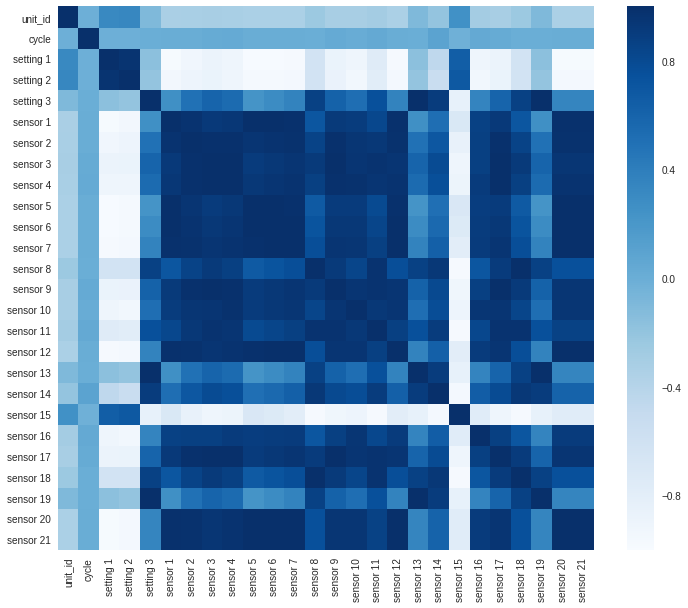

In [9]:
#co-relations of each setting and sensors in the training data using seaborn heatmap
plt.figure(figsize=(12,10), facecolor='white')

#heatmap for correlations, ignores satistical numbers for simple output
sns.heatmap(train_df.corr(), annot=False, cmap='Blues')

In [0]:
#for convenience, identify the sensor and operational setting columns

#sensors, 21 columns
sensor_columns = [col for col in train_df.columns if col.startswith("sensor ")]

#setting, 3 columns
setting_columns = [col for col in train_df.columns if col.startswith("setting ")]

**Sensor behaviours**

- The figure below shows some readings from the sensors on a single engine in a particular data set. Each of the sensors measures something about the physical state of the engine, in example; temperature, vibration or the speed of a fan.
- Notice that some sensor channels are quite noisy and appear to increase or decrease over time, while others don’t appear to change at all.

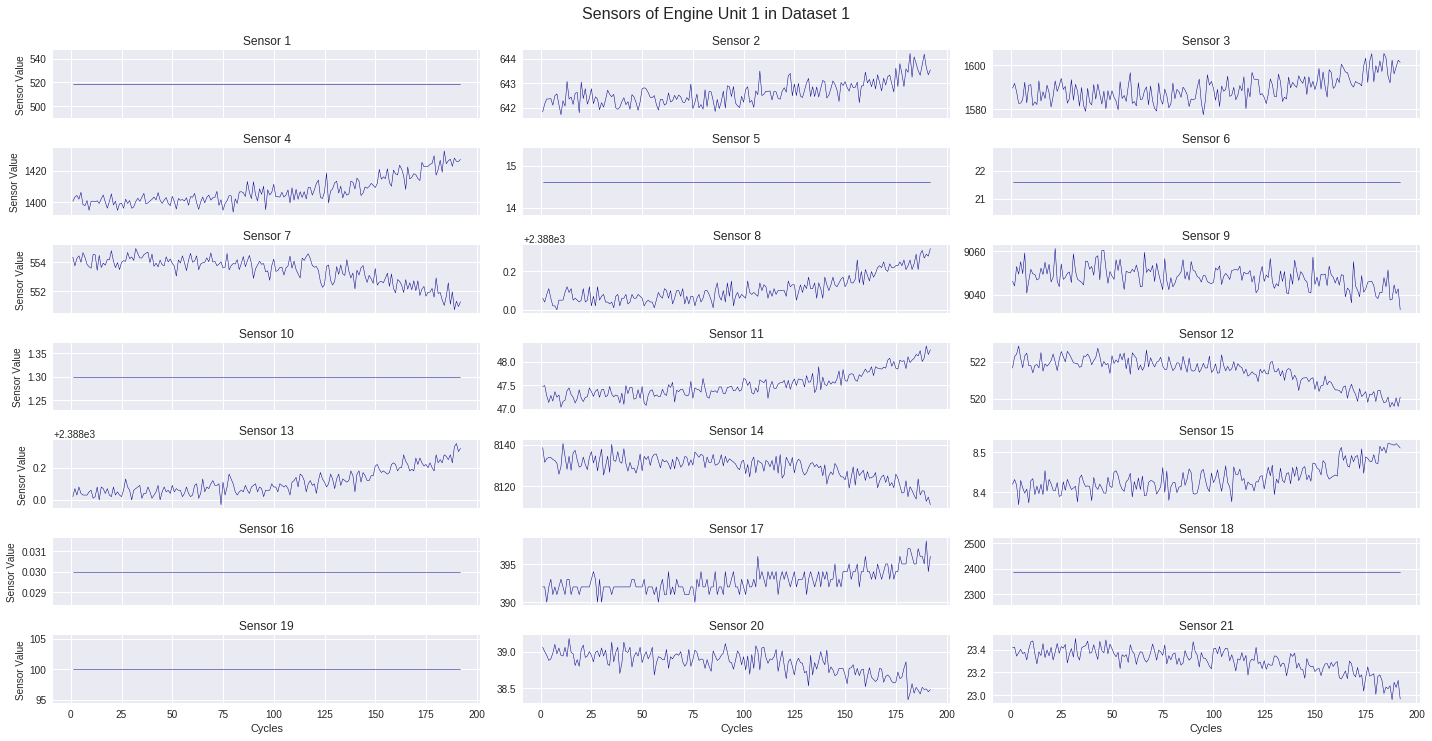

In [11]:
#extract the first engine unit from the first dataset
example_slice = train_df[(train_df.dataset_id == 'FD001') & (train_df.unit_id == 1)]


#plot its sensor traces over time, note we need 7 x 3 = 21 plots to see all sensor channels
fig, axes = plt.subplots(7, 3, figsize=(20, 10), sharex=True, facecolor='white')

#looping over sensors
for index, ax in enumerate(axes.ravel()):
    
    #plot the channel corresponding to this position
    sensor_col = sensor_columns[index]
    example_slice.plot(x='cycle', y=sensor_col, ax=ax, color='darkblue', lw=0.5);
    
    #label formatting
    if index % 3 == 0:
        ax.set_ylabel("Sensor Value", size=10);
    
    else:
        ax.set_ylabel("");
    
    ax.set_xlabel("Cycles");
    ax.set_title(sensor_col.title(), size=12);
    ax.legend_.remove();

#plot formatting
fig.suptitle("Sensors of Engine Unit 1 in Dataset 1", size=16, y=1.025)
fig.tight_layout();

- Also as given in the task statement, each engine starts with a different level of wear, and is allowed to run until failure. In the training set, all of the sensor measurements are recorded at all time steps up until the moment of failure.

- Below figure shows all 21 sensor channels for a random 10 engines from the training set, plotted against cycle

- It’s clear that, may be due to their different initial conditions, each engine had a slightly different lifetime and failure pattern.

- This highlights the fact that each engine’s progress in time is not quite aligned with any other, which means, for instance, that we can’t directly compare the fifth cycle of one engine to the fifth cycle of another.

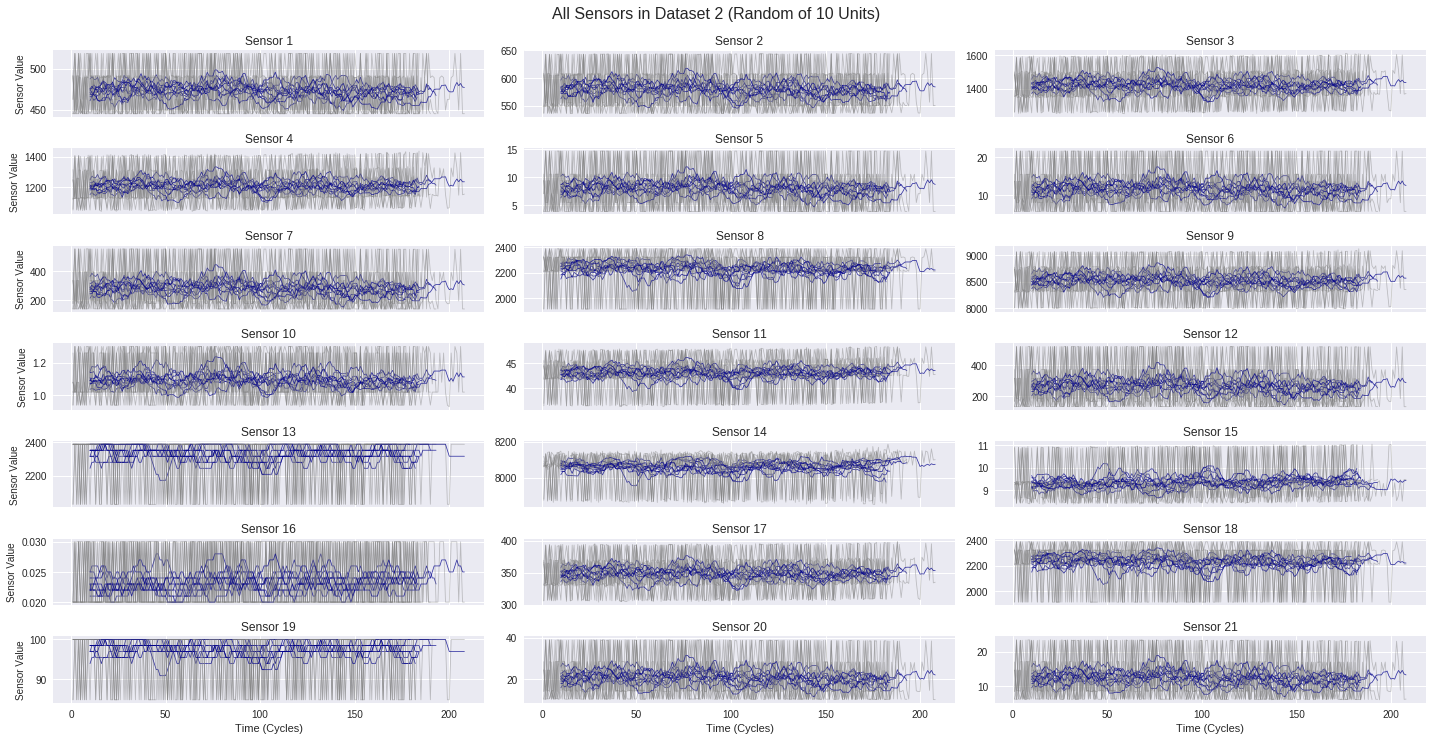

In [12]:
#randomly select 10 units from dataset 1 to plot
all_units = train_df[train_df['dataset_id'] == 'FD002']['unit_id'].unique()
units_to_plot = np.random.choice(all_units, size=10, replace=False)

#get the data for these units
plot_data = train_df[(train_df['dataset_id'] == 'FD002') & (train_df['unit_id'].isin(units_to_plot))].copy()

#plot their sensor traces (overlaid)
fig, axes = plt.subplots(7, 3, figsize=(20, 10), sharex=True, facecolor='white')

for index, ax in enumerate(axes.ravel()):
    
    sensor_col = sensor_columns[index]
    
    for unit_id, group in plot_data.groupby('unit_id'):
        
        # plot the raw sensor trace
        (group.plot(x='cycle', y=sensor_col, alpha=0.45, ax=ax, color='gray', lw=0.8, legend=False));
        
        # overlay the 10-cycle rolling mean sensor trace for visual clarity
        (group.rolling(window=10, on='cycle').mean().plot(x='cycle', y=sensor_col, alpha=.75, ax=ax, color='darkblue', lw=0.8, legend=False));
    
    #label formatting
    if index % 3 == 0:
        ax.set_ylabel("Sensor Value", size=10);
    
    else:
        ax.set_ylabel("");
    
    ax.set_title(sensor_col.title());
    ax.set_xlabel("Time (Cycles)");

#plot formatting
fig.suptitle("All Sensors in Dataset 2 (Random of 10 Units)", size=16, y=1.025);
fig.tight_layout();

**When is the failure**

- As we know when each engine will fail, we can compute a “time before failure” at each time step, defined as an engine’s elapsed life at that time minus its total lifetime.

- This number is a sort of countdown to failure for each engine, and it allows us to align different engines’ data to a common end point.

- The figure below shows the sensor channels from the same engines as the previous figure, now plotted against their time before failure. Note that each engine now ends at t=0 as indicated by the red line.

In [0]:
#method computes the number of cycles remaining before failure
def cycles_until_failure(r, lifetimes):
  
  #returns the number of cycles remaining before failure corresponding to this particular row
  return r['cycle'] - lifetimes.ix[(r['dataset_id'], r['unit_id'])]

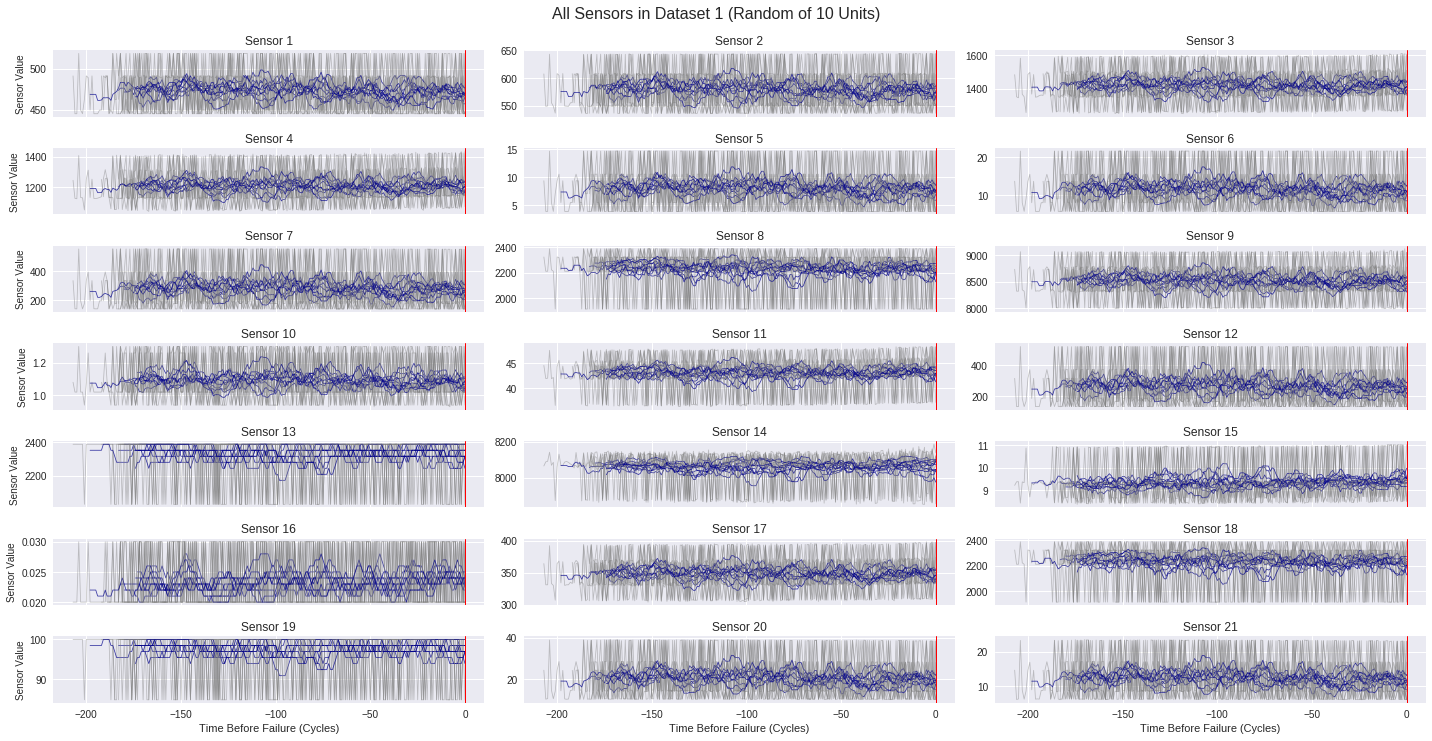

In [14]:
#generate the lifetimes series
lifetimes = train_df.groupby(['dataset_id', 'unit_id'])['cycle'].max()

#apply the above function to the data we're plotting
plot_data['ctf'] = plot_data.apply(lambda r: cycles_until_failure(r, lifetimes), axis=1)


#plot the sensor traces (overlaid)
fig, axes = plt.subplots(7, 3, figsize=(20, 10), sharex=True, facecolor='white')

for index, ax in enumerate(axes.ravel()):
    
    sensor_col = sensor_columns[index]
    
    #use the same subset of data as above
    for unit_id, group in plot_data.groupby('unit_id'):
        
        #plot the raw sensor trace, using ctf on the time axis
        (group.plot(x='ctf', y=sensor_col, alpha=0.45, ax=ax, color='gray', legend=False, lw=0.8));
        
        #overlay the 10-cycle rolling mean sensor trace for visual clarity
        (group.rolling(window=10, on='ctf').mean().plot(x='ctf', y=sensor_col, alpha=.75, ax=ax, color='darkblue', legend=False, lw=0.8));
    
    #label formatting
    if index % 3 == 0:
        ax.set_ylabel("Sensor Value", size=10);
    
    else:
        ax.set_ylabel("");
    
    ax.set_title(sensor_col.title());
    ax.set_xlabel("Time Before Failure (Cycles)");
    
    #add a vertical red line to signal common time of failure
    ax.axvline(x=0, color='r', linewidth=1);
    
    #extend the x-axis to compensate 
    ax.set_xlim([None, 10]);
    
fig.suptitle("All Sensors in Dataset 1 (Random of 10 Units)", size=16, y=1.025);
fig.tight_layout();

- Above figure supports us to observe some patterns. For instance, we see that some sensor readings consistently rise or fall right before a failure, while others exhibit different failure behavior across different engines.
- The test set is similar to the training set, except that each engine’s measurements are truncated some amount of time before it fails.
- And similarly we can observe settings in the figure below, it also illustrates that while setting 1 and 2 are flactuating, setting 3 kept quite.

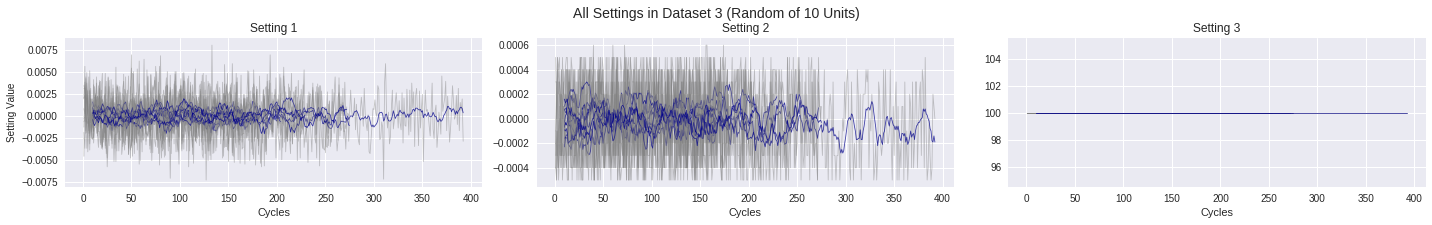

In [15]:
#randomly select 10 units from dataset 1 to plot
all_units = train_df[train_df['dataset_id'] == 'FD003']['unit_id'].unique()
units_to_plot = np.random.choice(all_units, size=10, replace=False)

#get the data for these units
plot_data = train_df[(train_df['dataset_id'] == 'FD003') & (train_df['unit_id'].isin(units_to_plot))].copy()

#plot their setting traces (overlaid)
fig, axes = plt.subplots(1, 3, figsize=(20, 3), sharex=True, facecolor='white')

for index, ax in enumerate(axes.ravel()):
    sensor_col = setting_columns[index]
    
    for unit_id, group in plot_data.groupby('unit_id'):
        
        #plot the raw sensor trace
        (group.plot(x='cycle', y=sensor_col, alpha=0.45, ax=ax, color='gray', lw=0.8, legend=False));
        
        #overlay the 10-cycle rolling mean setting trace for visual clarity
        (group.rolling(window=10, on='cycle').mean().plot(x='cycle', y=sensor_col, alpha=.75, ax=ax, color='darkblue', lw=0.8, legend=False));
        
    #label formatting
    if index % 3 == 0:
        ax.set_ylabel("Setting Value", size=10);
    
    else:
        ax.set_ylabel("");
    
    ax.set_title(sensor_col.title());
    ax.set_xlabel("Cycles");

#plot formatting
fig.suptitle("All Settings in Dataset 3 (Random of 10 Units)", size=14, y=1.025);
fig.tight_layout();

**dataset_id - does it matter ?**

- Yes, it is. As mentioned in the task statement, the data is collected as a number of datasets each with its own engines (meaning engines nr1 in data set X and  nr1 in data set Y are not the same engine).
- We have to consider the dataset id for predictions, but we cannot proceed with string values, so as a solution lets make some dummies.

In [0]:
#making some dummies for the dataset_id column 
data_id = pd.get_dummies(train_df['dataset_id'], drop_first=True)

#merge the generated dummies with train dataset
train_df = pd.concat([train_df, data_id], axis=1)

#drop the dataset_id column from the train dataset
train_df.drop(['dataset_id'], axis=1, inplace=True)

**RUL for training dataset**
- Lets compute the RUL values using cycle count in tha train data, so we can use them to train the model, which we gonna create

In [0]:
#new dataframe for rul
rul = pd.DataFrame(train_df.groupby('unit_id')['cycle'].max()).reset_index()

#naming its columns
rul.columns = ['unit_id', 'max']

#merging happens
train_df = train_df.merge(rul, on=['unit_id'], how='left')

#computing rul
train_df['RUL'] = train_df['max'] - train_df['cycle']

#drop the max which used to compute rul
train_df.drop('max', axis=1, inplace=True)

#need to reset index, otherwise sometimes it gives an error when doing column wise operations
train_df = train_df.reset_index()

In [18]:
#training dataset with computed RULs
train_df.head()

,index,unit_id,cycle,setting 1,setting 2,setting 3,sensor 1,sensor 2,sensor 3,sensor 4,...,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21,FD002,FD003,FD004,RUL
0,0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,...,0.02,330,2212,100.00,10.62,6.3670,0,0,1,320
1,1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,...,0.02,361,2324,100.00,24.37,14.6552,0,0,1,319
2,2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,...,0.02,329,2212,100.00,10.48,6.4213,0,0,1,318
3,3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,...,0.02,328,2212,100.00,10.54,6.4176,0,0,1,317
4,4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,...,0.02,305,1915,84.93,14.03,8.6754,0,0,1,316


- Same as above lets make some dummies to test dataset

In [0]:
#dataset_id of test dataset
test_data_id = pd.get_dummies(test_df['dataset_id'], drop_first=True)

#merge dummies with test dataset
test_df = pd.concat([test_df, test_data_id], axis=1)

- Remember we had around over 100k rows in test dataset where the real results are in total just 707 rows.
- Lets combine test dataset and real RUL
- There is a simple groupby method which we can be used to combine these two dataframes, but it casts all values to integers, so I am doing it my way. groupby inside iloc to avoid integer casting.

In [0]:
#getting each dataset seperate
fd001 = test_df[test_df['dataset_id'] == 'FD001'].reset_index()
fd002 = test_df[test_df['dataset_id'] == 'FD002'].reset_index()
fd003 = test_df[test_df['dataset_id'] == 'FD003'].reset_index()
fd004 = test_df[test_df['dataset_id'] == 'FD004'].reset_index()

#now group each dataset seperately by unit id and cycle
r1 = fd001.iloc[fd001.groupby('unit_id')['cycle'].agg(pd.Series.idxmax)]
r2 = fd002.iloc[fd002.groupby('unit_id')['cycle'].agg(pd.Series.idxmax)]
r3 = fd003.iloc[fd003.groupby('unit_id')['cycle'].agg(pd.Series.idxmax)]
r4 = fd004.iloc[fd004.groupby('unit_id')['cycle'].agg(pd.Series.idxmax)]

#make a temporary merging all datasets we created above
temp_df = pd.concat([r1, r2, r3, r4])

- Now both real results and test dataset are just 707 rows, so lets combine them accordingly

In [21]:
#combine two dataframes according to dataset id and unit id
test_df = pd.merge(temp_df, rul_df, on=['dataset_id', 'unit_id'], how='left')

#drop the dataset id column from the test dataset
test_df.drop(['dataset_id'], axis=1, inplace=True)

#view first five
test_df.head()

,index,unit_id,cycle,setting 1,setting 2,setting 3,sensor 1,sensor 2,sensor 3,sensor 4,...,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21,FD002,FD003,FD004,rul
0,57840,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,...,0.03,393,2388,100.0,38.81,23.3552,0,0,0,112
1,57889,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,...,0.03,391,2388,100.0,38.81,23.2618,0,0,0,98
2,58015,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,...,0.03,395,2388,100.0,38.93,23.2740,0,0,0,69
3,58121,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,...,0.03,395,2388,100.0,38.58,23.2581,0,0,0,82
4,58219,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,...,0.03,394,2388,100.0,38.75,23.4117,0,0,0,91


**Organise Train Test Splits**
- Since our train and test datasets are passed their pre-process stage, lets make train test splits which will be used in the network

In [22]:
#training features
X_train = train_df.iloc[:,1:30]

#training labels
y_train = train_df.iloc[:,30:31]

#print both training features and labels
print(X_train.head())
print(y_train.head())

#convert dataframes to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

   unit_id  cycle  setting 1  setting 2  setting 3  sensor 1  sensor 2  \
0        1      1    42.0049     0.8400      100.0    445.00    549.68   
1        1      2    20.0020     0.7002      100.0    491.19    606.07   
2        1      3    42.0038     0.8409      100.0    445.00    548.95   
3        1      4    42.0000     0.8400      100.0    445.00    548.70   
4        1      5    25.0063     0.6207       60.0    462.54    536.10   

   sensor 3  sensor 4  sensor 5  ...    sensor 15  sensor 16  sensor 17  \
0   1343.43   1112.93      3.91  ...       9.3335       0.02        330   
1   1477.61   1237.50      9.35  ...       9.1913       0.02        361   
2   1343.12   1117.05      3.91  ...       9.4007       0.02        329   
3   1341.24   1118.03      3.91  ...       9.3369       0.02        328   
4   1255.23   1033.59      7.05  ...      10.8366       0.02        305   

   sensor 18  sensor 19  sensor 20  sensor 21  FD002  FD003  FD004  
0       2212     100.00      10.62 

**Why**
- All setting columns - because they all play important roles
- All sensor columns - at the begining I though of droping the sensors which was flat in the behaviour charts, but realised it was a bad idea as they all are important
- unit_id - because each engine is unique
- dataset_id - as there are many datasets and unit_id number 1 in the dataset 1 not equals to unit_id number 1 in the dataset 2

- Finally RUL column as labels

In [23]:
#doing the same with the test dataset
X_test = test_df.iloc[:,1:30]
y_test = test_df.iloc[:,30:31]

print(X_test.head())
print(y_test.head())

X_test = np.array(X_test)
y_test = np.array(y_test)

   unit_id  cycle  setting 1  setting 2  setting 3  sensor 1  sensor 2  \
0        1     31    -0.0006     0.0004      100.0    518.67    642.58   
1        2     49     0.0018    -0.0001      100.0    518.67    642.55   
2        3    126    -0.0016     0.0004      100.0    518.67    642.88   
3        4    106     0.0012     0.0004      100.0    518.67    642.78   
4        5     98    -0.0013    -0.0004      100.0    518.67    642.27   

   sensor 3  sensor 4  sensor 5  ...    sensor 15  sensor 16  sensor 17  \
0   1581.22   1398.91     14.62  ...       8.4024       0.03        393   
1   1586.59   1410.83     14.62  ...       8.4505       0.03        391   
2   1589.75   1418.89     14.62  ...       8.4119       0.03        395   
3   1594.53   1406.88     14.62  ...       8.4634       0.03        395   
4   1589.94   1419.36     14.62  ...       8.4362       0.03        394   

   sensor 18  sensor 19  sensor 20  sensor 21  FD002  FD003  FD004  
0       2388      100.0      38.81 

**Normalise**
- Since this is a regression analysis, where the relationships are of interest, however, normalisation can reach a linear, more robust relationship.

In [0]:
#creating an object of MinMaxScaler from preprocessing
min_max_scalar = preprocessing.MinMaxScaler()

#normalising training data
X_train = min_max_scalar.fit_transform(X_train)

#normalising test data
X_test = min_max_scalar.fit_transform(X_test)

In [25]:
#finally train test splits using normalised data we generated above
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.7, shuffle=True)

#checking their shapes
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(112251, 29) (112251, 1) (48108, 29) (48108, 1) (707, 29) (707, 1)


In [26]:
timesteps = 1

#printing sample sizes
print("Training samples: {}".format(X_train.shape[0]))
print("Validation samples: {}".format(X_valid.shape[0]))
print("Testing samples: {}".format(X_test.shape[0]))


#reshaping samples
X_train = X_train.reshape((X_train.shape[0], timesteps, X_train.shape[1]))
X_valid = X_valid.reshape((X_valid.shape[0],timesteps, X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0],timesteps, X_test.shape[1]))

y_train = y_train.reshape((X_train.shape[0], timesteps))
y_valid = y_valid.reshape((X_valid.shape[0], timesteps))
y_test = y_test.reshape((X_test.shape[0], timesteps))


#printing new shapes
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Training samples: 112251
Validation samples: 48108
Testing samples: 707
(112251, 1, 29) (112251, 1) (707, 1, 29) (707, 1)


**Neural Network**
- Keras sequential model
- LSTM
- two hidden layers
- ReLu activation function
- RMSprop optimiser
- L2 regularisation

I have tried activation and dropout layers to avoid overfitting but it was not successful.

also have tried 
- different numbers of epochs, batch sizes
- passing the input data without normalising them
- batch normalisation
- different kind of activation in different layer combinations
- reshape input data and use a convo layer with average pool 

likewise, i have tried few different approaches but finally settled with these settings.

In [0]:
#sequancial nn 
model = Sequential()

#layer 01 - LSTM with input size 50 and specific shape given
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False, use_bias=True))

#layer 02 - general dense with L2 regulariser, try to avoid large fluctations
model.add(Dense(50,use_bias=True,  kernel_regularizer=regularizers.l2(-0.00001)))

#layer 03 - general dense, relu is being used to avoid negatives
model.add(Dense(1, use_bias=True, bias_initializer='ones', activation='relu'))

#absolute error cost function and rmspro for optimiser
model.compile(loss='mae', optimizer='RMSprop')

**Train the model**

In [35]:
%%time

history = model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_valid, y_valid), verbose=1, shuffle=True)

Train on 112251 samples, validate on 48108 samples
Epoch 1/10
112251/112251 [==============================] - 10s 90us/step - loss: 83.9529 - val_loss: 72.6447
Epoch 2/10
112251/112251 [==============================] - 9s 83us/step - loss: 59.3654 - val_loss: 53.7075
Epoch 3/10
112251/112251 [==============================] - 9s 83us/step - loss: 53.3427 - val_loss: 52.4822
Epoch 4/10
112251/112251 [==============================] - 9s 83us/step - loss: 52.9081 - val_loss: 53.5658
Epoch 5/10
112251/112251 [==============================] - 9s 83us/step - loss: 52.5282 - val_loss: 51.8613
Epoch 6/10
112251/112251 [==============================] - 9s 83us/step - loss: 52.0765 - val_loss: 51.7296
Epoch 7/10
112251/112251 [==============================] - 9s 84us/step - loss: 51.5448 - val_loss: 50.5937
Epoch 8/10
112251/112251 [==============================] - 9s 83us/step - loss: 51.0578 - val_loss: 50.1415
Epoch 9/10
112251/112251 [==============================] - 9s 82us/step - l

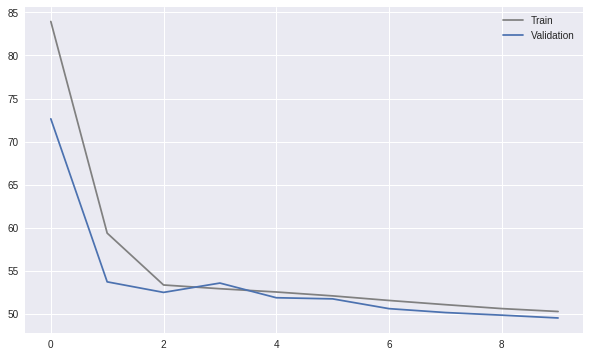

In [36]:
#plotting the loss and validation loss
plt.figure(figsize=(10,6), facecolor='white')

#get losses from the history saved
plt.plot(history.history['loss'], label='Train', color='gray')
plt.plot(history.history['val_loss'], label='Validation') 

#graph legend
plt.legend()  
plt.show()

**Make predictions**

In [0]:
#make predictions using the model we created and trained
predictions = model.predict(X_test)

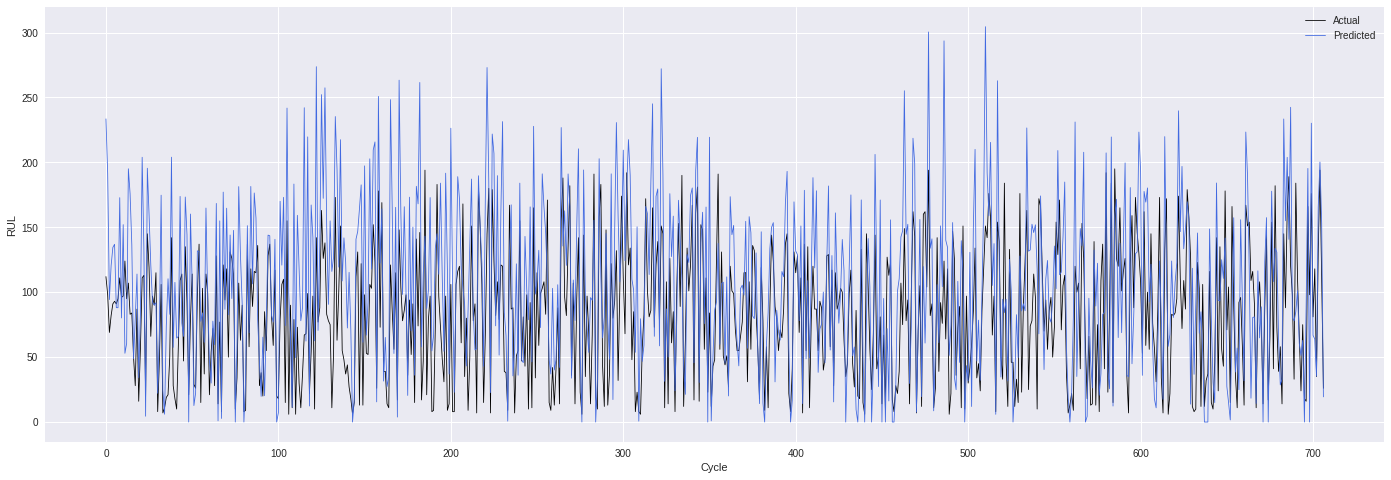

In [38]:
#plot them
plt.figure(figsize=(24,8), facecolor='white')

#get length of the results
cycles = np.arange(len(y_test))

#plot cycles agaonts real
plt.plot(cycles, y_test, 'black', label="Actual", lw=0.8)

#plot cycles against predictions made
plt.plot(cycles, predictions, 'royalblue', label="Predicted", lw=0.8)

#axis labels
plt.xlabel("Cycle")
plt.ylabel("RUL")

#graph legend
plt.legend()
plt.show()

In [39]:
#absolute error of the model using sklearn
metrics.mean_absolute_error(y_test, predictions)

43.29669065101143

In [40]:
#finally the summary of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                16000     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 18,601
Trainable params: 18,601
Non-trainable params: 0
_________________________________________________________________
